In [27]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from data.image import CS_Images
from data.config import BRAIN_VISA_PATH, CS_CORRECTED
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

import SimpleITK as sitk

from skimage import measure

from skimage import measure, morphology

Found 308 subjects and 308 MPRAGE images
Found 13 subjects with both BrainVisa and corrected from 308 subjects


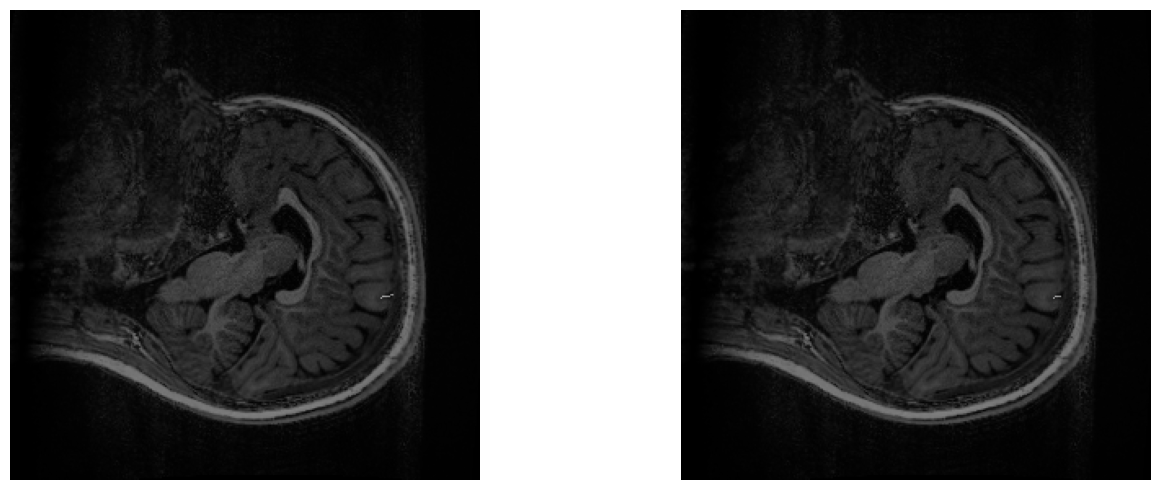

In [28]:
cs_paths = [x for x in Path(BRAIN_VISA_PATH).glob(CS_CORRECTED)]
dataset = CS_Images(segmentation='all',
                    mesh=True,
                    preload=False)

s0 = dataset[0]
img = sitk.GetArrayFromImage(s0['img'])
bvisa = sitk.GetArrayFromImage(s0['bvisa'])
corrected = sitk.GetArrayFromImage(s0['corrected'])
caseid = s0['caseid']
center = s0['centre']
slc = 100

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img[slc, :, :].T, cmap='gray')
axs[0].imshow(bvisa[slc, :, :].T, alpha=0.5, cmap='gray')
axs[0].set_axis_off()

axs[1].imshow(img[slc, :, :].T, cmap='gray')
axs[1].imshow(corrected[slc, :, :].T, alpha=0.5, cmap='gray')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

In [29]:
bvisa_cc = measure.label(bvisa, connectivity=2)

bvisa_dil = morphology.closing(bvisa, morphology.ball(3))
bvisa_dil = morphology.closing(bvisa_dil, morphology.ball(3))
bvisa_dil_cc = measure.label(bvisa_dil, connectivity=2)

In [30]:
print(np.unique(bvisa_cc, return_counts=True))
print(np.unique(bvisa_dil_cc, return_counts=True))

(array([0, 1, 2]), array([15921676,     1721,     1851]))
(array([0, 1, 2]), array([15920764,     2123,     2361]))


## Hit and Miss transform

In [7]:
# # create a SE with a 3x3x3 cube with two oposite corners of the cube set to 1

# SE_f = np.zeros((3, 3, 3), dtype=np.bool_)
# SE_f[0, 1, 1] = True
# SE_f[2, 1, 1] = True
# print(SE_f)

# SE_b = np.zeros((3, 3, 3), dtype=np.bool_)
# SE_b[1, 1, :] = True
# # print('\n______________\n', SE_b)

# SE_rotX = [np.rot90(SE_f, k=1, axes=(0, 1)),]

[[[False False False]
  [False  True False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False  True False]
  [False False False]]]


In [9]:
SE_f = np.zeros((5, 5, 5), dtype=np.bool_)
SE_f[1, 0, 2] = True #z (green), y (red), x (blue)
SE_f[1, 4, 2] = True
SE_f[2, 0, 2] = True
SE_f[2, 4, 2] = True
SE_f[3, 0, 2] = True
SE_f[3, 4, 2] = True
print(SE_f)

SE_b = np.zeros((5, 5, 5), dtype=np.bool_)
SE_b[1, 2, 2] = True

SE_b[2, 2, 2] = True
SE_b[2, 2, 3] = True
SE_b[2, 3, 2] = True
SE_b[2, 1, 2] = True
SE_b[2, 2, 1] = True

SE_b[3, 2, 2] = True

# print('\n______________\n', SE_b)

# SE_rotX = [np.rot90(SE_f, k=1, axes=(0, 1)),]

[[[False False False False False]
  [False False False False False]
  [False False False False False]
  [False False False False False]
  [False False False False False]]

 [[False False  True False False]
  [False False False False False]
  [False False False False False]
  [False False False False False]
  [False False  True False False]]

 [[False False  True False False]
  [False False False False False]
  [False False False False False]
  [False False False False False]
  [False False  True False False]]

 [[False False  True False False]
  [False False False False False]
  [False False False False False]
  [False False False False False]
  [False False  True False False]]

 [[False False False False False]
  [False False False False False]
  [False False False False False]
  [False False False False False]
  [False False False False False]]]


In [19]:
SE_bank = [(SE_f, SE_b),
           # 90 deg rotation around x axis
           (np.rot90(SE_f, k=1, axes=(0, 1)),
            np.rot90(SE_b, k=1, axes=(0, 1))),
           # 90 deg rotation around y axis
           (np.rot90(SE_f, k=1, axes=(0, 2)),
            np.rot90(SE_b, k=1, axes=(0, 2)))]

In [20]:
np.unique(bvisa, return_counts=True)

(array([0, 1, 2], dtype=int16), array([15921320,     1962,     1966]))

In [21]:
bvisa_bin = bvisa == 1
hit_miss_result = np.zeros_like(bvisa, dtype=np.bool_)
for SE_f, SE_b in SE_bank:
    hit = morphology.erosion(bvisa_bin, SE_f)
    miss = morphology.erosion(~bvisa_bin, SE_b)
    hit_miss = hit & miss

    hit_miss_result = hit_miss_result | hit_miss

In [28]:
hit_miss_p = np.stack((hit_miss_result!=0).nonzero()).T
hit_miss_pcd = o3d.geometry.PointCloud()
hit_miss_pcd.points = o3d.utility.Vector3dVector(hit_miss_p[:,:3])
hit_miss_pcd.estimate_normals()
hit_miss_pcd.paint_uniform_color([1, 0, 0])


PointCloud with 1 points.

In [23]:
bvisa_pcd = np.stack((bvisa==1).nonzero()).T
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(bvisa_pcd[:,:3])
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd],)
pcd.paint_uniform_color([0, 1, 0])
vgrd = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, 1)


In [24]:
hmgrd = o3d.geometry.VoxelGrid.create_from_point_cloud(hit_miss_pcd, 1)
o3d.visualization.draw_geometries([vgrd,
                                  hmgrd],
                                  mesh_show_wireframe=True,
                                  mesh_show_back_face=False,
                                  point_show_normal=False)

## Simple Dilation

In [10]:
SE = np.array([[[0, 0, 0], [0, 1, 0], [0, 0, 0]],
               [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
               [[0, 0, 0], [0, 1, 0], [0, 0, 0]]])

In [11]:
def plot_point_grid(pts_list, pts_colors=[[0, 0, 0]]):
    pt_grid_list = []
    
    for idx, pts in enumerate(pts_list):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts[:,:3])
        pcd.paint_uniform_color(pts_colors[idx])
        pt_grid_list.append(o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, 1))
    
    o3d.visualization.draw_geometries(pt_grid_list,
                                       mesh_show_wireframe=True,
                                       mesh_show_back_face=False,
                                       point_show_normal=False)

In [12]:
se_pcd = np.stack((SE==1).nonzero()).T
plot_point_grid([se_pcd])

In [29]:
bvisa_cc = measure.label(bvisa==1, connectivity=2)
print(np.unique(bvisa_cc, return_counts=True))

bvisa_bin = bvisa == 1
bvisa_bin_pts = np.stack((bvisa_bin!=0).nonzero()).T
bvisa_closed = morphology.closing(bvisa_bin, morphology.ball(2))

print(np.unique(bvisa_closed, return_counts=True))

(array([0, 1], dtype=int32), array([15923286,     1962]))
(array([False,  True]), array([15922975,     2273]))


In [30]:
bvisa_closed_pcd = np.stack(bvisa_closed.nonzero()).T
plot_point_grid([bvisa_closed_pcd])

In [31]:
plot_point_grid([bvisa_bin_pts, bvisa_closed_pcd],
                [[0, 0, 0], [1, 0, 0]])

In [40]:
hole_candidates = np.bitwise_xor(bvisa_closed, bvisa_bin)
hole_candidates[bvisa_bin] = False
hole_cand_pts = np.stack(hole_candidates.nonzero()).T
plot_point_grid([hole_cand_pts])

In [39]:
bvisa_closed_dilated = morphology.dilation(bvisa_closed, SE)
bvisa_closed_border = np.bitwise_xor(bvisa_closed_dilated, bvisa_closed)
bvisa_closed_border_pts = np.stack(bvisa_closed_border.nonzero()).T
plot_point_grid([bvisa_closed_border_pts])

In [42]:
hole_candidates = np.bitwise_xor(bvisa_closed, bvisa_bin)
hole_candidates[bvisa_closed_border] = False
hole_cand_pts = np.stack(hole_candidates.nonzero()).T
plot_point_grid([hole_cand_pts])

## Open3D Didn't Work

In [16]:
bunny = o3d.data.BunnyMesh()
mesh = o3d.t.geometry.TriangleMesh.from_legacy(o3d.io.read_triangle_mesh(bunny.path))
filled = mesh.fill_holes(10000000000)

In [17]:
bmesh = o3d.io.read_triangle_mesh(bunny.path)
bmesh.compute_vertex_normals()

TriangleMesh with 35947 points and 69451 triangles.

In [18]:
o3d.visualization.draw_geometries([bmesh])

In [19]:
fbmesh = filled.to_legacy()
fbmesh.compute_vertex_normals()

TriangleMesh with 35947 points and 69652 triangles.

In [20]:
o3d.visualization.draw_geometries([fbmesh])

## PyVista Didn't Work (but worked on their example)

In [21]:
import numpy as np
from pymeshfix import MeshFix
from pymeshfix._meshfix import PyTMesh
from pymeshfix.examples import planar_mesh
import pyvista as pv

In [22]:
p = p='/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/CFIN/sub-via248/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_best/segmentation/RSulci_sub-via248_default_session_best.ply'

/mrhome/vladyslavz/anaconda3/envs/csshape/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


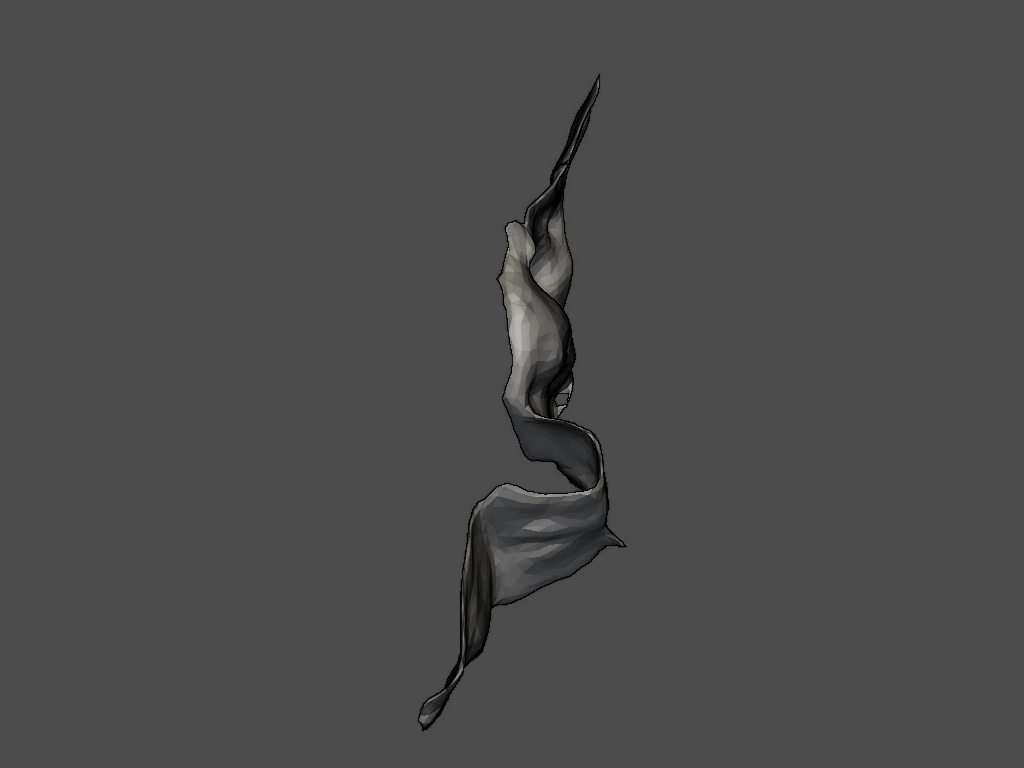

In [23]:
orig_mesh = pv.read(p)
# orig_mesh.plot_boundaries()

meshfix = MeshFix(orig_mesh)
holes = meshfix.extract_holes()

# Render the mesh and outline the holes
plotter = pv.Plotter()
plotter.add_mesh(orig_mesh, color=True)
# plotter.add_mesh(holes, color="r", line_width=5)
plotter.enable_eye_dome_lighting()  # helps depth perception
_ = plotter.show()

In [24]:
orig_mesh = pv.read(p)
mfix = PyTMesh(False)  # False removes extra verbose output
mfix.load_file(p)

# Fills all the holes having at at most 'nbe' boundary edges. If
# 'refine' is true, adds inner vertices to reproduce the sampling
# density of the surroundings. Returns number of holes patched.  If
# 'nbe' is 0 (default), all the holes are patched.
mfix.fill_small_boundaries(nbe=1000000000, refine=True)

0

In [25]:
vert, faces = mfix.return_arrays()
triangles = np.empty((faces.shape[0], 4), dtype=faces.dtype)
triangles[:, -3:] = faces
triangles[:, 0] = 3

mesh = pv.PolyData(vert, triangles)

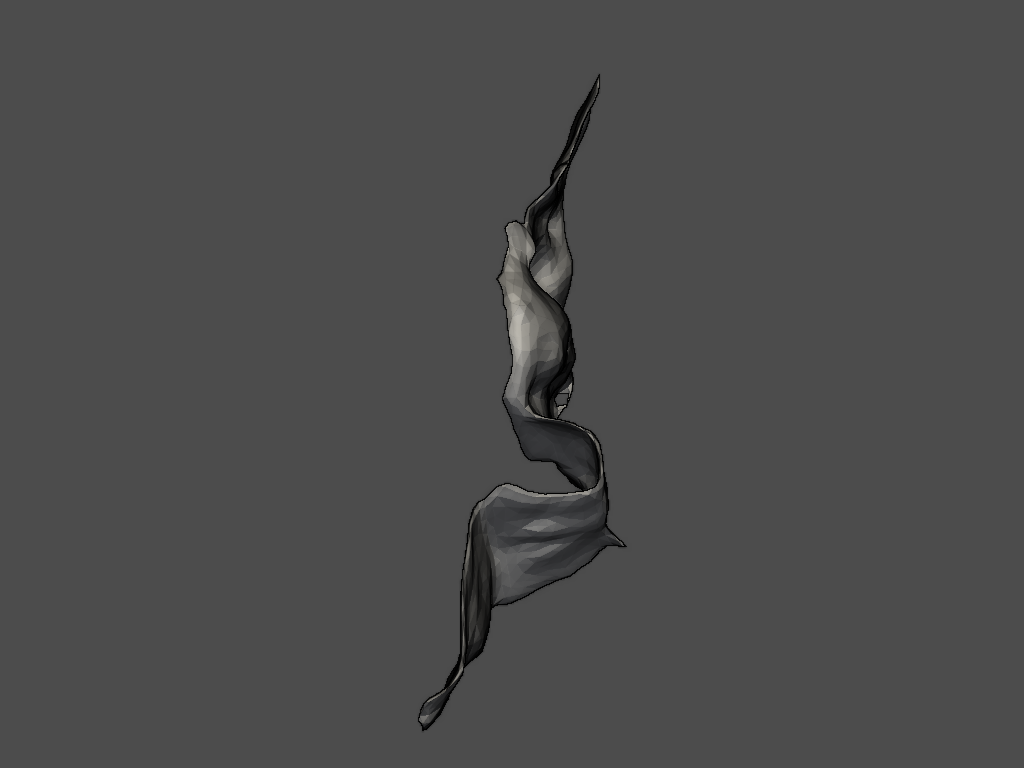

In [26]:
plotter = pv.Plotter()
plotter.add_mesh(mesh, color=True)
# plotter.add_mesh(holes, color="r", line_width=5)
plotter.enable_eye_dome_lighting()  # helps depth perception
_ = plotter.show()

## Trimesh

In [27]:
import trimesh

In [28]:
m = trimesh.creation.box()

In [30]:
m.fill_holes()

True

In [ ]:
light = trimesh.scene.lighting.DirectionalLight()
light.intensity = 10
scene = trimesh.Scene([m], lights=[light])
scene.show(viewer='notebook')